# NYCU 2022 Machine Learning (Homework3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from scipy.stats import multivariate_normal

# you can choose one of the following package for image reading/processing
# import cv2
import PIL

In [2]:
from PIL import Image
from matplotlib.pyplot import imread
from sklearn.svm import SVC

----

## 1. Support Vector Machine

In [3]:
from collections import Counter

In [4]:
data = pd.read_csv("./x_train.csv",header= None) / 255
label = pd.read_csv("./t_train.csv",header= None)

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.007843,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.058824,0.627451,0.603922,...,0.403922,0.090196,0.000000,0.007843,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.007843,0.011765,0.000000,0.000000,...,0.419608,0.482353,0.282353,0.000000,0.011765,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.015686,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.368627,0.313725,0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [6]:
label.head()

,0
0,1.0
1,2.0
2,1.0
3,0.0
4,0.0


In [7]:
x = np.array(data)
t = np.array(label)

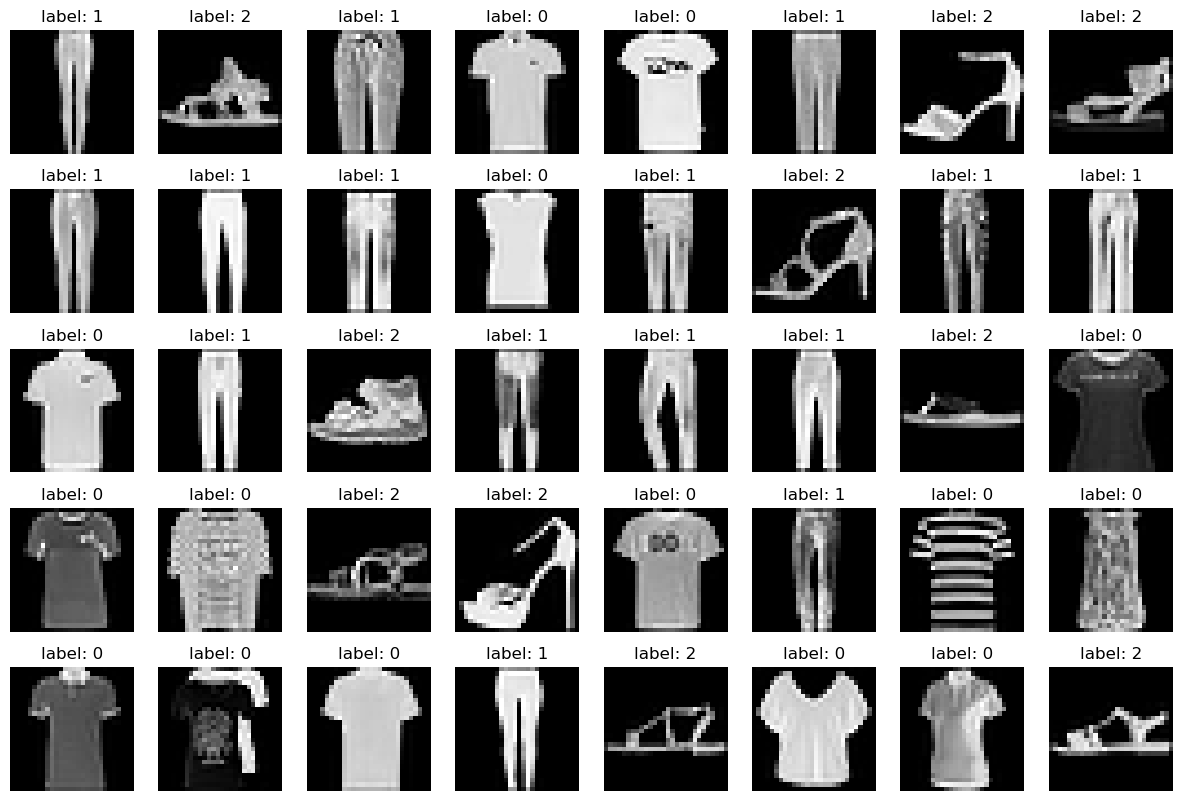

In [8]:
fig = plt.figure(figsize=(15,10))
for i in range(40):  
    ax = fig.add_subplot(5, 8, i+1)
    ax.imshow(x[i].reshape(28,28), cmap='gray')
    
    ax.set_title('label: {y}'.format(y=t[i][0].astype(int)))
    plt.axis('off')

#### 1.1

In [9]:
def PCA(data, d):
    U, S, V = np.linalg.svd(data)
    SS = np.zeros(data.shape)
    for i in range(len(S)):
        SS[i][i]=S[i]

    Ud = U[:, 0:d]
    Sd = SS[0: d, 0: d]
    Vd = V[0:d, :]
    pca = np.dot(np.dot(Ud, Sd), Vd)
    x = (Ud - np.mean(Ud)) / np.std(Ud)
    
    return Ud, x

In [10]:
d = 2
x_pca, train_x = PCA(x, d)

#### 1.2

* one-versus-the-rest (one-aganinst-all) : 訓練時，依序將其中一個類別的data歸為一類，其他的data歸為另一類。如此一來，若有k個類別，就會有k個classifier。分類時，將data帶入k個classifier，並將該data分類為具有最大分類函數值的類別。


* one-versus-one classifier: 在k個類別中，任選兩類得到一個classifier。因此，如果有k個類別，就會得到k(k-1)/2個classfier。分類時，將data分類為得票最多的類別。

1. 透過 PCA 將 Data 降成2維

2. 計算 kernel
    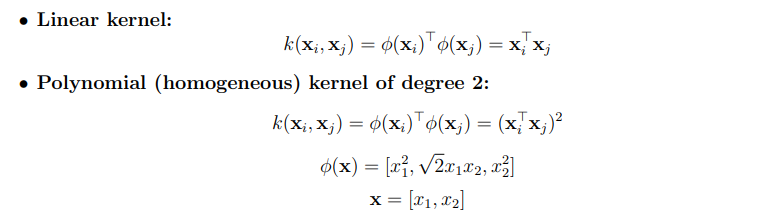
    
3. 使用 scikit-learn 套件的 SVC 計算 support vector

4. 計算出Lagarange multiplier及target

5. SVM 使用 one-versus-the-rest來分類，總共3次，所以會有3個classifier。首先計算出weight與bias，接著就可算出y
    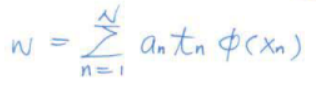
    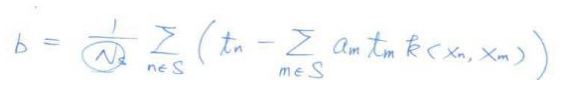
    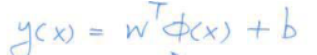
    總共求出3條decision boundary
    
     - class 0 vs. class 1
    
     - class 0 vs. class 2
    
     - class 1 vs. class 2
     
     

我使用 one-versus-one 作為我的decision strategy，因為分類多個類別的資料(multiclass)，假設有n個類別，可以一次找出其中一個類別與其他類別的邊界，如此一來就可以一次訓練好模型，在預測的時候比較方便。

In [11]:
class SVM(object):
    def __init__(self, k_type='linear', X=0, T=0):
        self.k_type = k_type
        self.class_group = [(0, 1), (0, 2), (1, 2)]
        self.C = 1
        self.X = X
        self.T = T
        self.supvec = None
        self.supvec_idx = None
        self.k = None
        self.xx = None
        self.yy = None
        
    
    # Define Kernel
    def Kernel(self, x):
        if self.k_type == 'linear':
            self.k = x
        else: # poly
            if len(x.shape) == 1:
                self.k = np.vstack((x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2)).T
            else:
                self.k = np.vstack((x[:, 0]**2, np.sqrt(2)*x[:, 0]*x[:, 1], x[:, 1]**2)).T

        return self.k

    # support vectors
    def sv(self):
        if self.k_type == 'linear':
            clf = SVC(kernel='linear', C=self.C, decision_function_shape='ovo')
        else:
            clf = SVC(kernel='poly', C=self.C, degree=2, decision_function_shape='ovo')

        clf.fit(self.X, self.T)
        self.supvec = np.abs(clf.dual_coef_)
        self.supvec_idx = clf.support_
    
    # target & multiplier
    def create_target_multiplier(self):
        self.sv()
        
        # one-against-all method
        # multiplier
        multiplier = np.zeros([len(self.X), 2])
        multiplier[self.supvec_idx] = self.supvec.T 

        multiplier_ = {}
        multiplier_[(0, 1)] = np.concatenate((multiplier[:200, 0], np.zeros(100)))
        multiplier_[(0, 2)] = np.concatenate((multiplier[:100, 1], np.zeros(100), multiplier[200:, 0]))
        multiplier_[(1, 2)] = np.concatenate((np.zeros(100), multiplier[100:, 1]))
        
        # target 
        target_ = {}
        target_[(0, 1)] = np.concatenate((np.ones(100), np.full([100], -1), np.zeros(100)))
        target_[(0, 2)] = np.concatenate((np.ones(100), np.zeros(100), np.full([100], -1)))
        target_[(1, 2)] = np.concatenate((np.zeros(100), np.ones(100), np.full([100], -1)))

        

        return target_, multiplier_

    # main function
    def svm(self):
        # train 3 classifier
        target_, multiplier_ = self.create_target_multiplier()
        weight_ = {}
        b_ = {}
        for c1, c2 in self.class_group:
            # get weight
            at = multiplier_[(c1, c2)] * target_[(c1, c2)]
            weight_[(c1, c2)] = np.dot(at, self.Kernel(self.X))

            # get bias
            M_dominate = np.where(((multiplier_[(c1, c2)] > 0) & (multiplier_[(c1, c2)] < 1)))[0]
            S_dominate = np.nonzero(multiplier_[(c1, c2)])[0]
            tn = target_[(c1, c2)][M_dominate]
            b = tn - np.dot(at[S_dominate], np.dot(self.X[M_dominate],self.X[S_dominate].T).T)
            b_[(c1, c2)] = np.mean(b)
      

        # decision boundary
        space = 0.2
        x_min, x_max = self.X[:, 0].min() - space, self.X[:, 0].max() + space
        y_min, y_max = self.X[:, 1].min() - space, self.X[:, 1].max() + space
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

        # make prediction
        pred = []
        XX = np.column_stack((self.xx.flatten(), self.yy.flatten()))
        for index in range(len(XX)):
            votes = []
            for c1, c2 in self.class_group:
                w = weight_[(c1, c2)]
                b = b_[(c1, c2)]
                y = np.dot(w.T, self.Kernel(XX[index]).T) + b
                
                if y > 0:
                    votes += [c1]
                else:
                    votes += [c2]
            pred += [Counter(votes).most_common()[0][0]]
            
        return pred
      
    def plot_scatter(self, pred):
        # plot
        c0_indices = np.where(self.T == 0)[0]
        c1_indices = np.where(self.T == 1)[0]
        c2_indices = np.where(self.T == 2)[0]
        plt.scatter(self.X[self.supvec_idx,   0], self.X[self.supvec_idx, 1], facecolors='none', edgecolors='k', linewidths=2, label="Support vector")
        plt.scatter(self.X[c0_indices][:, 0], self.X[c0_indices][:, 1], c='r', marker='x', label="T-shirt/top")
        plt.scatter(self.X[c1_indices][:, 0], self.X[c1_indices][:, 1], c='b', marker='x', label="Trouser")
        plt.scatter(self.X[c2_indices][:, 0], self.X[c2_indices][:, 1], c='g', marker='x', label="Sandal")
        
        plt.contourf(self.xx, self.yy, np.array(pred).reshape(self.xx.shape), alpha=0.3, cmap='OrRd')
        plt.legend()

#### 1.3

### Linear Kernel

/home/bakerchen/.conda/envs/ML_training/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


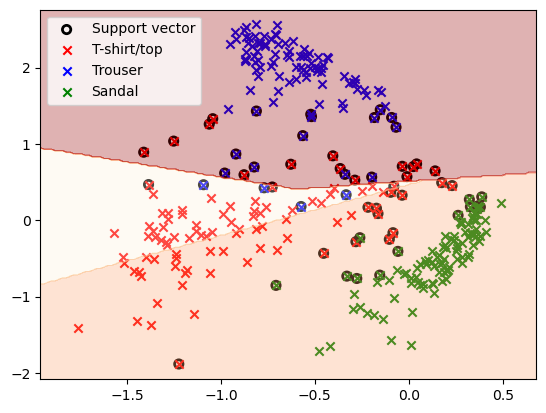

In [12]:
svm_linear = SVM(k_type='linear', X=train_x, T=t)
linear_pred = svm_linear.svm()
svm_linear.plot_scatter(linear_pred)

#### Bonus

### Polynomial kernel (degree = 2)

/home/bakerchen/.conda/envs/ML_training/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


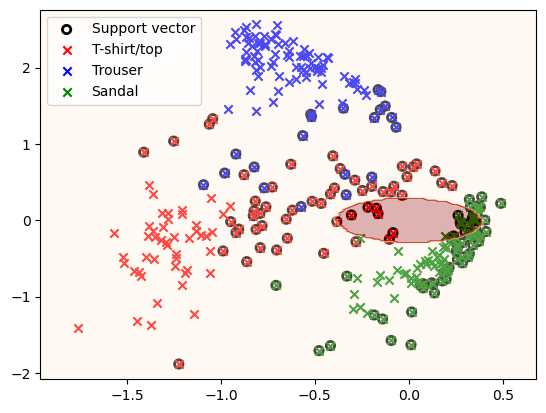

In [13]:
svm_poly = SVM(k_type='poly', X=train_x, T=t)
poly_pred = svm_poly.svm()
svm_poly.plot_scatter(poly_pred)

-----

## 2. Gaussian Mixture Model

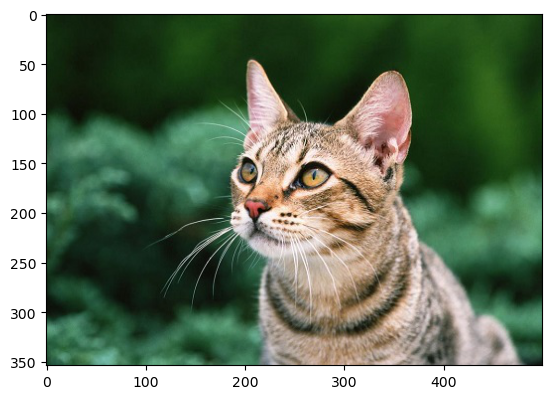

In [14]:
filePath = "./hw3.jpg"
img = imread(filePath)
plt.imshow(img)

In [15]:
h, w, c = img.shape
img = img.reshape(h*w, 3) / 255 # normalization

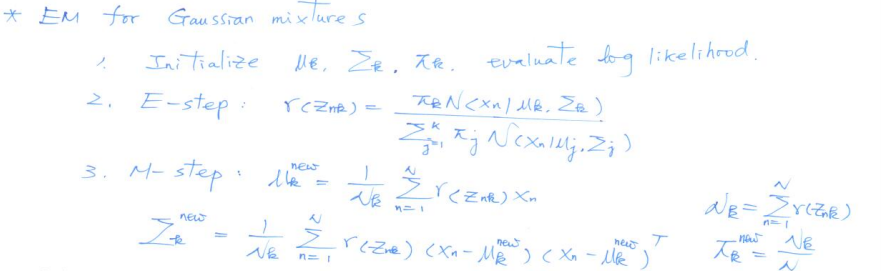

在dataset中隨機找K筆資料作為初始群集的中心，並計算每一筆data到K個群集中心的距離，並將該筆data分類給與之翠接近的群集中心，並產生一個群集邊界，在計算每個群集新的中心，在利用新群集中心計算距離，透過這樣的迭代方式，直到群集成員不再變動。
Expectation Maximization(EM) algorithm可以用來解決存在影藏資訊最佳化問題，將K-means計算出mean、variance與mixing coefficient等參數，在經由EM algorithm最佳化。

In [16]:
def Kmeans(data, k, iterat, debug):
    mu = data[np.random.randint(0, high=len(data), size=k)]
    rnk = np.zeros([data.shape[0], k])
    r = np.eye(k)
    
    for i in range(iterat):
        rnk_ = rnk
        dist = data.reshape(data.shape[0], 1, 3) - mu
        dist = np.sum(dist**2, axis=2)
        class_k = np.argmin(dist, axis=1)
        rnk = r[class_k]
        
        if np.array_equal(rnk, rnk_):
            break
        else:
            mu = np.sum(rnk.reshape(data.shape[0], k, 1) * data.reshape(data.shape[0], 1, 3), axis=0)
            mu /= np.sum(rnk, axis=0).reshape(k, 1)
            
    mu = (mu * 255).astype(int)
    
    if debug:
        dic = {'R':mu[:,0],'G':mu[:,1],'B':mu[:,2]}
        print("K={}".format(k))
        print(pd.DataFrame.from_dict(dic),'\n')
    
    return mu, rnk

def EM(data, mu, rnk, k, iterat, debug):
    log_list = []
    pi = np.sum(rnk, axis = 0) / len(rnk)
    mu_init = mu/255
    
    cov = np.array([np.cov(data[np.where(rnk[:, i] == 1)[0]].T) for i in range(len(rnk.T))])
    gau = np.array([multivariate_normal.pdf(data, mu_init[i], cov[i]) for i in range(len(rnk.T))])
    
    for i in range(iterat):
        # E-step
        r = (gau / np.sum(gau, axis=0)).T
        
        # M-step 
        mu_ = np.sum(r.reshape(data.shape[0], k, 1) * data.reshape(data.shape[0], 1, 3), axis=0)
        mu_ /= np.sum(r, axis=0).reshape(k, 1)
        
        for j in range(k):
            cov[j] = (r[:, j, None] * (data - mu_[j])).T.dot(data - mu_[j]) / np.sum(r, axis=0)[j]
        
        pi = np.sum(r, axis = 0) / len(data)
        
        for j in range(k):
            gau[j] = multivariate_normal.pdf(data, mu_[j], cov[j]) * pi[j]
            
        log_likelihood = np.sum(np.log(np.sum(gau, axis=0))) # log likelihood
        log_list.append(log_likelihood)
        
    mu_ = (mu_ * 255).astype(int)
    
    if debug:
        dic = {'R':mu_[:,0],'G':mu_[:,1],'B':mu_[:,2]}
        print("K={}".format(k))
        print(pd.DataFrame.from_dict(dic),'\n')
    return log_list, mu_, gau


In [17]:
def plot_Kmeans(K, img):
    print("---- K-means ----")
    fig, ax = plt.subplots(figsize = (15,10))
    
    for idx, k in enumerate(K):
        plt.subplot(2, 2, idx+1)
        mu, rnk = Kmeans(img, k, 300, True)
        data = (mu[np.argmax(rnk.T, axis=0)]).astype(int)
        plt.imshow(data.reshape(h, w, c))
        plt.gca().set_title("K = " + str(k))
        plt.axis('off')

    fig.suptitle("K-means")
    plt.show()


def plot_GMM(K, img):
    print("------ GMM ------")
    fig, ax = plt.subplots(figsize = (15,20))

    for idx, k in enumerate(K):
        plt.subplot(4, 2, idx+1)
        mu, rnk = Kmeans(img, k, 300, False)
        log, mu_, gau = EM(img, mu, rnk, k, 100, True)
        data = (mu_[np.argmax(gau, axis=0)]).astype(int)
        plt.imshow(data.reshape(h, w, c))
        plt.gca().set_title("K = " + str(k))
        plt.axis('off')
        
        plt.subplot(4, 2, idx+5)
        plt.plot(log)
        plt.gca().set_title("K = " + str(k))

    fig.suptitle("GMM")
    plt.show()

#### 2.1, 2.2, 2.3

In [18]:
K = [2, 3, 7, 20]

---- K-means ----
K=2
     R    G    B
0  177  165  147
1   35   68   37 

K=3
     R    G    B
0   24   54   23
1   84  119   90
2  201  177  163 

K=7
     R    G    B
0   59  101   72
1  190  166  149
2  149  123  102
3   18   40   16
4   81  139  105
5  229  208  199
6   32   72   30 

K=20
      R    G    B
0    21   51   17
1    55  109   77
2   100  157  125
3    68  124   91
4    34   76   49
5    38   85   24
6    90   76   56
7   192  154  129
8    17   38   17
9    44   94   64
10   26   67   19
11  159  131  109
12  202  177  163
13   81  141  105
14   28   57   34
15  243  225  218
16  222  199  189
17   15   26   12
18  126  106   85
19  166  158  149 



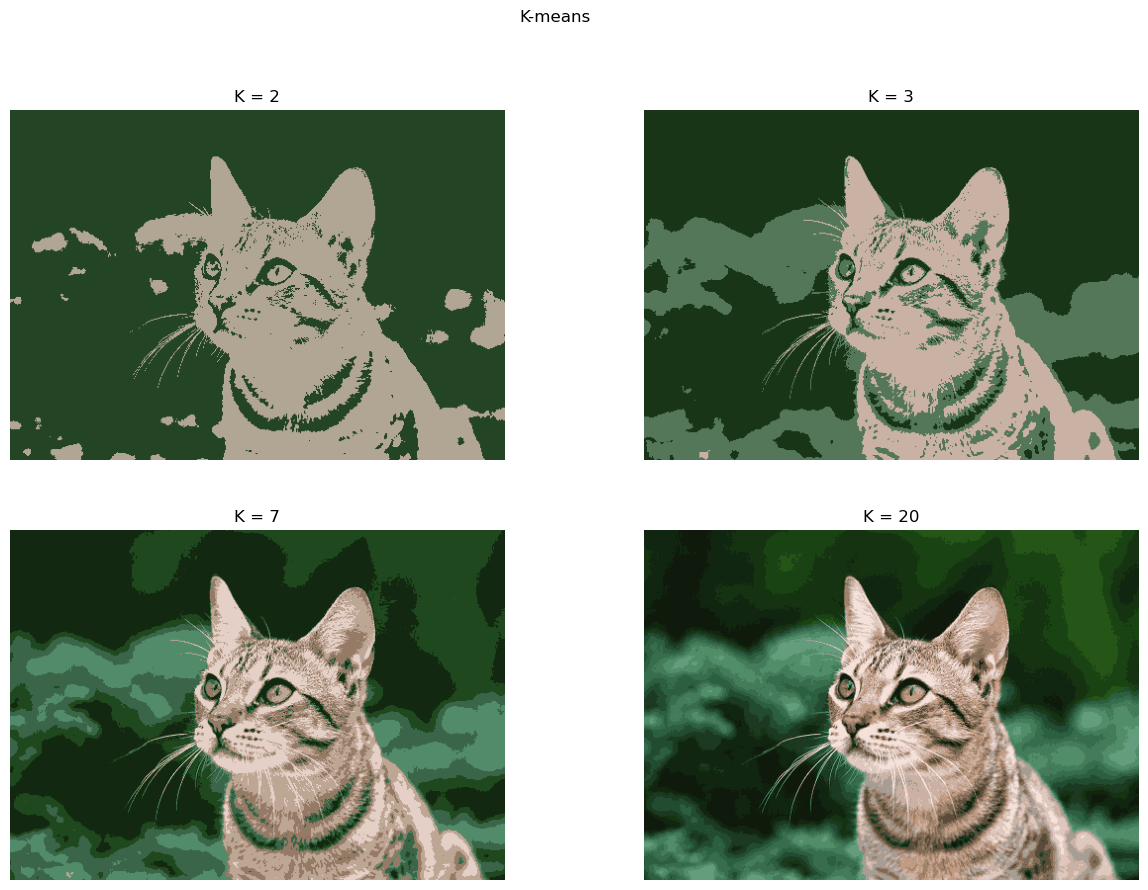

In [19]:
plot_Kmeans(K, img)

------ GMM ------
K=2
     R    G    B
0   34   72   40
1  173  152  136 

K=3
     R    G    B
0  172  151  135
1   49   96   66
2   22   51   16 

K=7
     R    G    B
0  134  123  109
1   19   41   23
2   60  115   81
3   20   48   15
4  210  195  191
5   34   79   22
6  174  150  128 

K=20
      R    G    B
0    43   90   62
1   127  107   83
2    56  111   79
3    81  141  100
4    71  127   89
5   172  151  135
6    18   39   18
7    73  136  100
8   139  128  115
9    32   52   31
10   15   31   19
11   15   30   11
12  242  221  213
13  204  164  148
14  207  183  165
15   26   63   38
16   35   80   22
17   23   60   16
18  203  190  188
19   18   45   15 



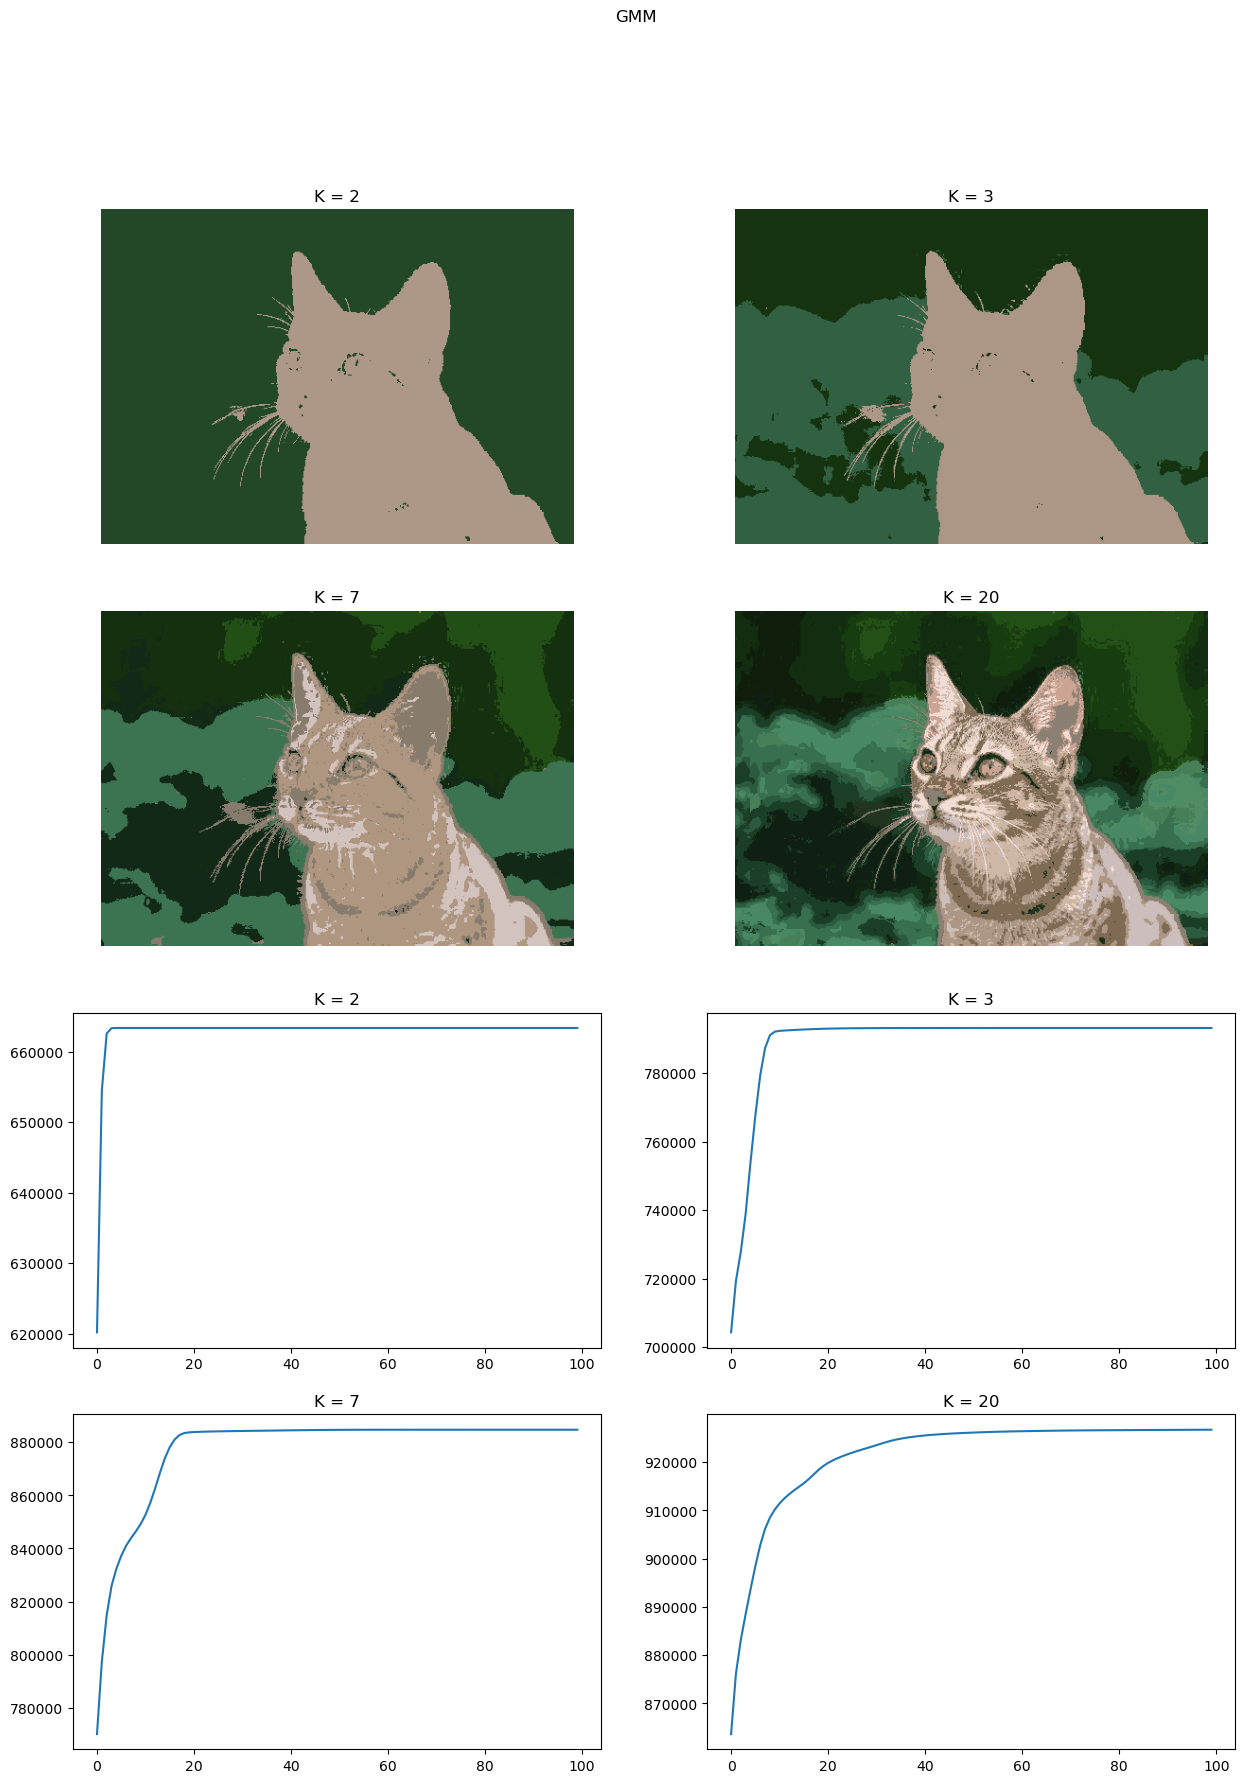

In [20]:
plot_GMM(K, img)

#### 2.4

當K值變大，分割的類別變多，圖像變的更清晰。由實驗結果觀察，K-menas可以更好保留原圖的資訊，細節保留的比較完整(例如:貓毛)。GMM則比較容易看出各個群集的顏色(例如:輪廓)。